In [2]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from joblib import dump
import seaborn as sns

<AxesSubplot:xlabel='edge_diff'>

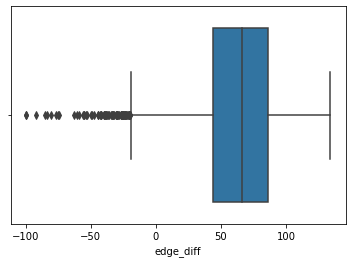

In [3]:
dat = pd.read_csv("analysis_result.csv")
#dat.drop(['b', 'g', 'r', 'edge_entropy'], axis=1, inplace=True)
dat.head(1)
#dat = dat[dat.edge_diff > 0]
sns.boxplot(x=dat['edge_diff'])

In [151]:
len(dat)

7724

In [152]:
dat['adv'].unique()

array([0, 1], dtype=int64)

In [153]:
x = dat.iloc[:, :-1].values
x = normalize(x, norm='l2')
y = dat.iloc[:,-1].values

In [154]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
#y_train = y_train.reshape([len(y_train), 1])
#y_test = y_test.reshape([len(y_test), 1])

In [155]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
dump(sc, 'Scaler.bin', compress=True)

['Scaler.bin']

In [156]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [157]:
keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

clf = Sequential([
    Dense(512, kernel_initializer='uniform', input_dim=8, activation='elu'),
    Dense(1024, kernel_initializer='uniform', activation='elu'),
    #Dense(1024, kernel_initializer='uniform', activation='elu'),
    Dropout(0.1),
    Dense(512, kernel_initializer='uniform', activation='elu'),
    Dense(1, kernel_initializer='uniform', activation='sigmoid')
])

In [158]:
clf.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               4608      
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 513       
Total params: 1,055,233
Trainable params: 1,055,233
Non-trainable params: 0
_________________________________________________________________


In [159]:
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [160]:
clf.fit(x_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
169/169 [==============================] - 1s 8ms/step - loss: 0.3519 - accuracy: 0.8642

In [161]:
score = clf.evaluate(x_test, y_test, verbose=0)

print(clf.metrics_names)
print(score)

['loss', 'accuracy']
[0.3167974650859833, 0.8632441759109497]


In [162]:
from keras.models import load_model
clf.save('AEGuard.keras')

In [163]:
x_predict = [
    [7.3378496842073835,2005.3647338785904,4.504145408163265,32.902195839142415,33.678372772158376,33.41943138869921,75.08849557522123,0.2649477141230245],
    [7.347049941119418,2043.8005363495167,3.0113998724489797,32.896276164881336,33.6823649646088,33.42135887050986,31.436135009927202,0.19496323402345217]
    #[7.109481332039627,1181.620735253842,4.512117346938775,26.801098135999048,37.14988650707845,36.0490153569225,88.47173144876325,0.2652988602177302],
    #[7.145613536455951,1342.1639741820782,3.559470663265306,26.234164188403792,37.466724054725475,36.29911175687073,58.006718924972,0.2217159457752795],
]
x_predict = sc.transform(x_predict)
y_predict = clf.predict(x_predict)
y_predict

print("Predicted: ", y_predict[0][0], "- adversarial(> 0.5)")
print("Predicted: ", y_predict[1][0], "- original(< 0.5)")

Predicted:  1.0 - adversarial(> 0.5)
Predicted:  1.0 - original(< 0.5)
